In [2]:
import helperfunctions as hf

circuit, time_params, si_params, targ_param = hf.create_rodeo_circuit(num_sites = 2, J_input = 4, 
                                                                      U_input = 1, cycles = 2 , 
                                                                      iterations= 3, steps=5)

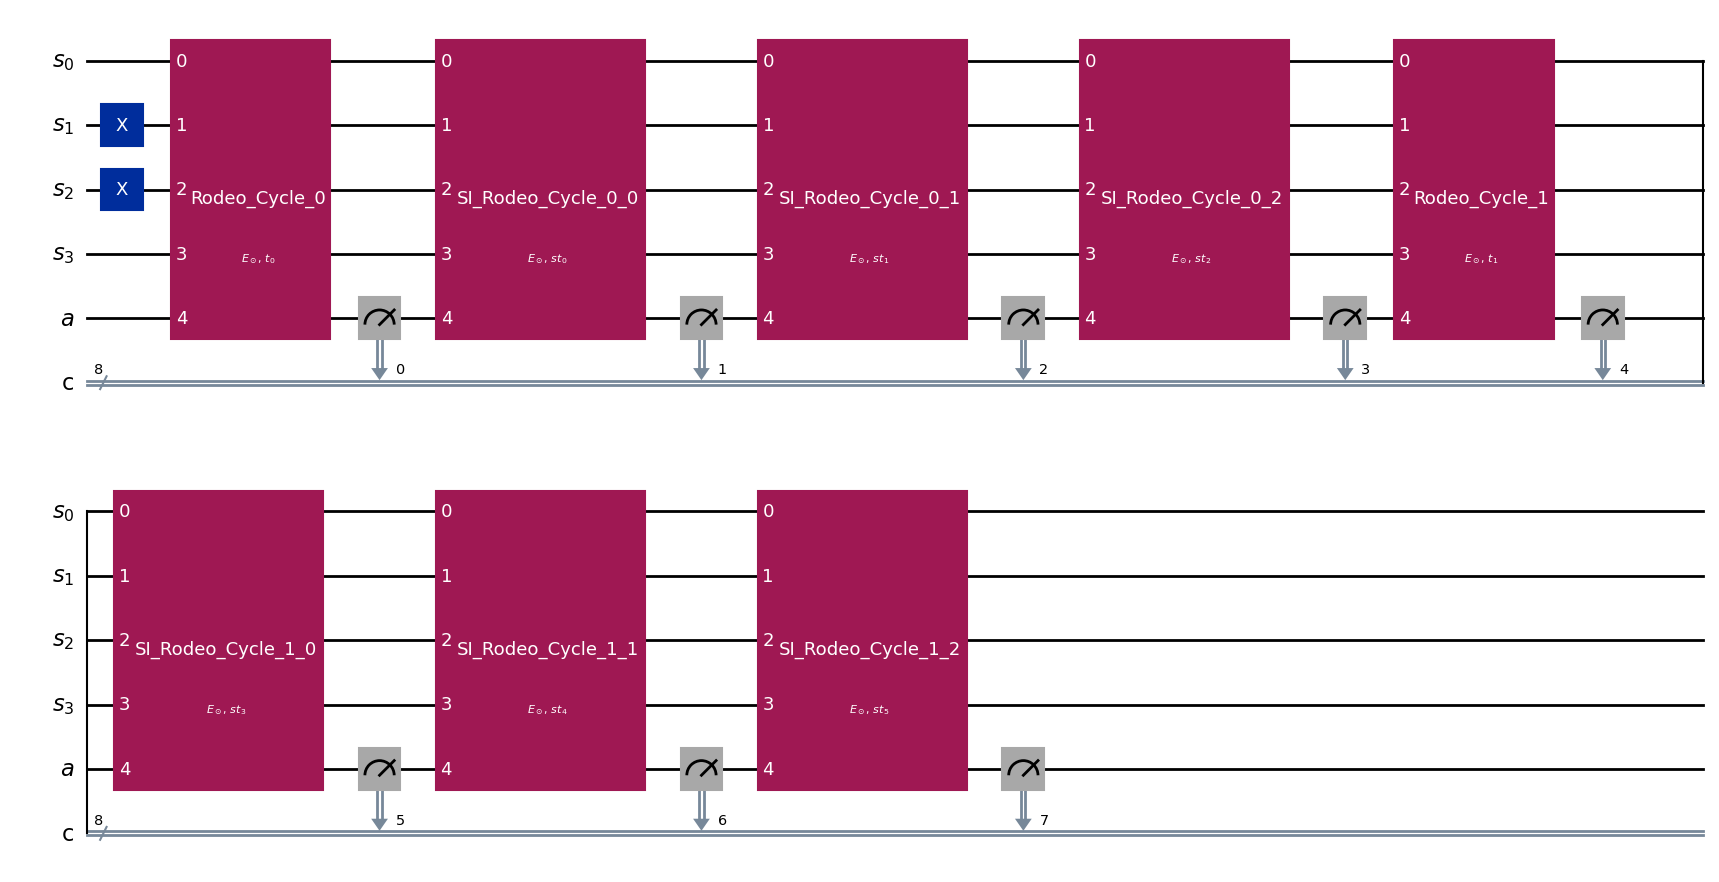

In [3]:
circuit.draw('mpl')

In [5]:
energylist, prob_list = hf.run_rodeo_simulation(circuit, time_params, si_params, targ_param,
                        energy_min = -10, energy_max = 10, delta_energy = 0.1,
                        gamma = 5, timeresamples = 10, shots_per_time = 1024)

Total expected measurements: 8
Cycles: 2, Iterations: 3


TypeError: cannot unpack non-iterable NoneType object

In [20]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)

    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

def generate_superiteration_times(tsamples, superiterations, si_time):

    # Validate the size of si_time
    if len(si_time) < len(tsamples) * superiterations:
        raise ValueError("Insufficient si_time parameters for the given cycles and superiterations.")
    
    superiteration_parameter_binds = {}
    

    for i in range(len(tsamples)):

        superiteration_times = []
        time = tsamples[i]
        for _ in range(superiterations):
            time /= 2
            superiteration_times.append(time)
        
        for j in range(superiterations):
            si_index = i * superiterations + j
            superiteration_parameter_binds[si_time[si_index]] = superiteration_times[j]
    
    return superiteration_parameter_binds

# Define circuit parameters
def create_rodeo_circuit(num_sites : int, J_input: float, U_input: float, cycles:int, superiterations:int,
                         steps:int):
    target_param = Parameter(r'$E_\odot$')
    time_params = [Parameter(fr'$t_{i}$') for i in range(cycles)]
    si_time_params = [Parameter(fr'$st_{j}$') for j in range(cycles * superiterations)]
    targ_list = [target_param] * cycles

    # Create registers and circuit
    classical = ClassicalRegister(cycles * (superiterations + 1), 'c')
    aux = QuantumRegister(1, 'a')
    sys = QuantumRegister(num_sites * 2, 's')
    circuit = QuantumCircuit(sys, aux, classical)

    # Initial state
    circuit.x([sys[1], sys[2]])

    # Create circuit with alternating rodeo cycles and super iterations
    classical_idx = 0
    super_idx = 0 

    for j in range(cycles):
        rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time_params[j], r=steps, targ=target_param)
        circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 

        # Add super iteration cycles with si_time
        for k in range(superiterations):
            rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time_params[super_idx],
                                         r=steps, targ=target_param)
            circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
            circuit.measure(aux, classical[classical_idx])
            classical_idx += 1 
            super_idx += 1

    if classical_idx < classical.size:
        circuit.measure(aux, classical[classical_idx])

    return circuit, target_param, time_params, si_time_params

    
num_sites = 2
J_input = 1.5
U_input = 1.0

# Initialize cycling parameters
cycles = 2
superiterations = 4
steps = 5

circuit, ep, tp, sp = create_rodeo_circuit(num_sites, J_input, U_input, cycles, superiterations, steps)

circuit.draw('mpl')

# Setup parameters

def run_rodeo_scan(circuit, energy_min: float, energy_max: float, delta_energy: float, shots: int, time_resamples: int,
                   time_params: Parameter, energy_param: Parameter, si_time_params: Parameter):
    energies = np.arange(-energy_min, energy_max+delta_energy, delta_energy)
    gamma = 1
    shots = 1024
    iterations = int(len(si_time_params)/len(time_params))

    data = []
    for energy in energies:
        print(f"Executing for Target Energy: {energy}")
        
        energy_runs = []
        for _ in range(time_resamples):
            # Generate time samples and parameters
            tsamples = (1/gamma) * np.random.randn(cycles)
            params = {
                energy_param: energy,
                **dict(zip(time_params, tsamples)),
                **generate_superiteration_times(tsamples, iterations, si_time_params)
            }
            
            # Run circuit
            result = Sampler().run(circuit.assign_parameters(params), shots=shots).result()
            energy_runs.extend(result.quasi_dists)
        
        # Average results
        combined = {}
        for dist in energy_runs:
            for k, v in dist.items():
                combined[k] = combined.get(k, 0) + v
        data.append({k: v/time_resamples for k, v in combined.items()})

    # Extract probabilities
    probs = [d.get(0, 0.0) for d in data]

    return probs


probs = run_rodeo_scan(circuit, energy_min = -10, energy_max = 10, delta_energy = 0.1, shots = 1024, time_resamples = 10,
                   time_params = tp, energy_param = ep, si_time_params = sp)

Executing for Target Energy: 10.0


C:\Users\sirac\AppData\Local\Temp\ipykernel_8304\3896310269.py:222: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  result = Sampler().run(circuit.assign_parameters(params), shots=shots).result()


QiskitError: 'Some classical bits are not used for measurements. the number of classical bits (10), the used classical bits ({9}).'

In [14]:
len(sp)/len(tp)

4.0